# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br>
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br>

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [85]:
# Install required packages directly in the notebook (only needed if not already installed)
!pip3 install wordcloud
!pip3 install imbalanced-learn
!pip3 install gensim
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from imblearn.under_sampling import ClusterCentroids, NearMiss, RandomUnderSampler
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import logging
from gensim.models import Word2Vec, KeyedVectors
from gensim.models import word2vec
# Importing the glove library

# ! pip3 install glove_python


# from glove import Corpus
# from glove import Glove

# Keras-related imports - Ensure you're using the correct imports for Keras with TensorFlow
from keras.preprocessing import sequence, text
from keras.layers import Dense, Dropout, Activation, Lambda, Embedding, Convolution1D, LSTM, SimpleRNN, GRU
from keras import backend as K
from keras.models import Sequential

# Matplotlib inline for Jupyter notebooks
%matplotlib inline

# Seaborn settings
sns.set_style("darkgrid")




You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


Exception ignored in: <function _releaseLock at 0x7fbf4d0c75e0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [ ]:
df= pd.read_csv('/Users/krithishetty/Downloads/Reviews.csv')


In [ ]:

#changing reviews with score less than 3 to be positive and vice-versa
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
df.shape

(568454, 10)

In [ ]:
review_count= df.Score.value_counts()
review_count

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

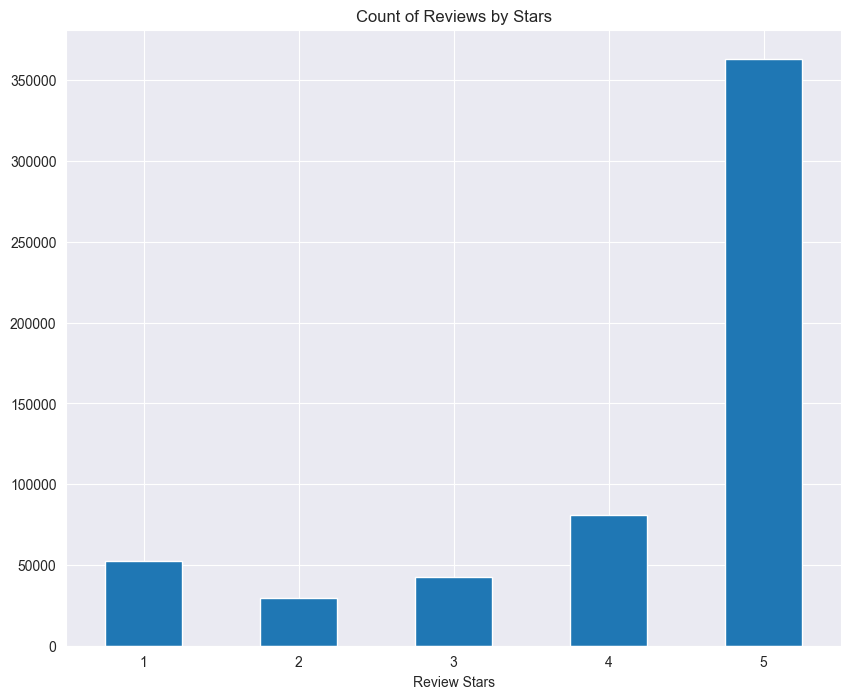

In [ ]:
# study the distribution of the five categories
ax = review_count.sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 8))
ax.set_xlabel('Review Stars')
plt.xticks(rotation=0) 
plt.show()

In [ ]:
df.isna().sum()


Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [ ]:
len(df['Id'].value_counts(dropna=False))

568454

In [ ]:
# Sample data based on the 'Score' column in the DataFrame `df`
one_star_reviews = df[df['Score'] == 1].sample(n=1500)
two_star_reviews = df[df['Score'] == 2].sample(n=500)
three_star_reviews = df[df['Score'] == 3].sample(n=500)
four_star_reviews = df[df['Score'] == 4].sample(n=500)
five_star_reviews = df[df['Score'] == 5].sample(n=1500)

# Optionally, you can combine these into a single DataFrame if needed
undersampled_reviews = pd.concat([one_star_reviews, two_star_reviews, three_star_reviews, four_star_reviews, five_star_reviews])


In [ ]:
undersampled_reviews['Score'].value_counts(dropna=False)

Score
1    1500
5    1500
2     500
3     500
4     500
Name: count, dtype: int64

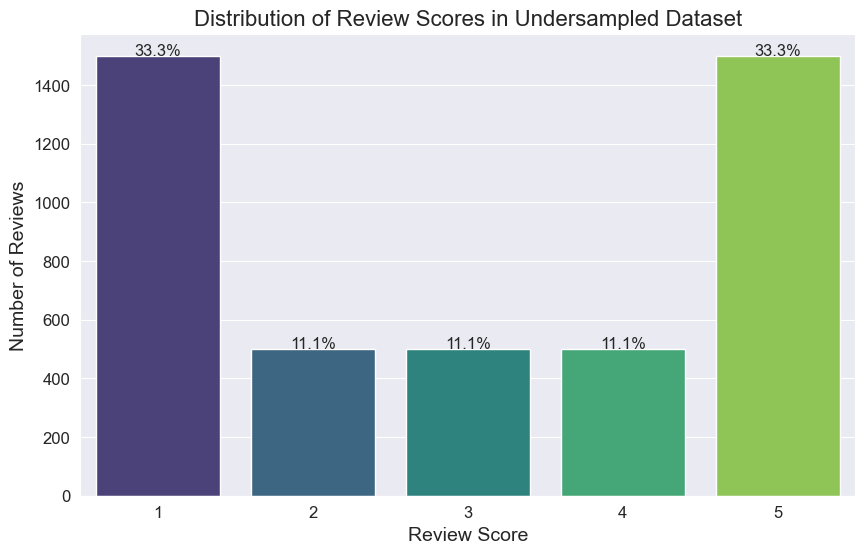

In [ ]:
# Create a count plot for the 'Score' column in the undersampled_reviews DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(data=undersampled_reviews, x='Score', palette='viridis')

# Add labels and a title
plt.title('Distribution of Review Scores in Undersampled Dataset', fontsize=16)
plt.xlabel('Review Score', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)

# Optionally, add a percentage on top of the bars
total = len(undersampled_reviews)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(
        p.get_x() + p.get_width() / 2., height + 3,
        f'{100 * height / total:.1f}%', ha="center", fontsize=12)

# Improve the x-axis label readability
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

In [ ]:
sample_100K_revs = df.sample(n=100000, random_state=42)
sample_100K_revs.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
165256,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
231465,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
427827,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
433954,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
70260,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...


In [ ]:
sample_100K_revs.to_csv("/Users/krithishetty/Downloads/samll_review_set.csv", index=False)

In [ ]:
undersampled_reviews.to_csv("/Users/krithishetty/Downloads/medium_review_set.csv", index=False)

#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
reviews=undersampled_reviews
reviews.shape

(4500, 10)

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br>
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br>
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
example = reviews['Text'].iloc[49]
print(example)

First thing out of many , many purchases over the years that I wasted my money on. I went by the reviews. Honestly I looked forward to this and then I smelled it.  It smelled bad. I mean REALLY "OFF". I couldn't get past the smell. I passed it to  my husband and he eats anything but one mouthful and he was done. The rice would have been okay on its own so we will throw the vegetable stuff away and just keep the "expensive" rice. I have eaten Indian many times so the smell was not due to the spices.


In [ ]:
nltk.word_tokenize(example)

['First',
 'thing',
 'out',
 'of',
 'many',
 ',',
 'many',
 'purchases',
 'over',
 'the',
 'years',
 'that',
 'I',
 'wasted',
 'my',
 'money',
 'on',
 '.',
 'I',
 'went',
 'by',
 'the',
 'reviews',
 '.',
 'Honestly',
 'I',
 'looked',
 'forward',
 'to',
 'this',
 'and',
 'then',
 'I',
 'smelled',
 'it',
 '.',
 'It',
 'smelled',
 'bad',
 '.',
 'I',
 'mean',
 'REALLY',
 '``',
 'OFF',
 "''",
 '.',
 'I',
 'could',
 "n't",
 'get',
 'past',
 'the',
 'smell',
 '.',
 'I',
 'passed',
 'it',
 'to',
 'my',
 'husband',
 'and',
 'he',
 'eats',
 'anything',
 'but',
 'one',
 'mouthful',
 'and',
 'he',
 'was',
 'done',
 '.',
 'The',
 'rice',
 'would',
 'have',
 'been',
 'okay',
 'on',
 'its',
 'own',
 'so',
 'we',
 'will',
 'throw',
 'the',
 'vegetable',
 'stuff',
 'away',
 'and',
 'just',
 'keep',
 'the',
 '``',
 'expensive',
 "''",
 'rice',
 '.',
 'I',
 'have',
 'eaten',
 'Indian',
 'many',
 'times',
 'so',
 'the',
 'smell',
 'was',
 'not',
 'due',
 'to',
 'the',
 'spices',
 '.']

In [ ]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['First',
 'thing',
 'out',
 'of',
 'many',
 ',',
 'many',
 'purchases',
 'over',
 'the']

In [ ]:
# part of speech tagging
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('First', 'RB'),
 ('thing', 'NN'),
 ('out', 'IN'),
 ('of', 'IN'),
 ('many', 'JJ'),
 (',', ','),
 ('many', 'JJ'),
 ('purchases', 'NNS'),
 ('over', 'IN'),
 ('the', 'DT')]

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
# Tag the tokens with their corresponding part of speech (POS)
pos_tagged_tokens = nltk.pos_tag(tokens)

# Display the first 10 tagged tokens in a more readable format
for token, tag in pos_tagged_tokens[:10]:
    print(f"Token: {token:<15} POS Tag: {tag}")

Token: First           POS Tag: RB
Token: thing           POS Tag: NN
Token: out             POS Tag: IN
Token: of              POS Tag: IN
Token: many            POS Tag: JJ
Token: ,               POS Tag: ,
Token: many            POS Tag: JJ
Token: purchases       POS Tag: NNS
Token: over            POS Tag: IN
Token: the             POS Tag: DT


In [ ]:
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize, sent_tokenize
from string import punctuation
from nltk.tokenize import TreebankWordTokenizer

In [ ]:
nltk.download("opinion_lexicon")

[nltk_data] Error loading opinion_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1131)>


False

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# Extract lists of positive and negative words from the opinion lexicon
positive_sentiment_words = list(opinion_lexicon.positive())
negative_sentiment_words = list(opinion_lexicon.negative())


In [ ]:
def get_sentiment_score_oplex(text):
    """
    Calculate the sentiment score of a given text using the NLTK opinion lexicon.
    
    Parameters:
        text (str): The input text to analyze.
    
    Returns:
        float: Sentiment score of the text; >0 indicates positive sentiment, <0 indicates negative sentiment.
    """    
    total_score = 0

    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    
    # Tokenizer and translation table for punctuation removal
    tokenizer = TreebankWordTokenizer()
    translation_table = str.maketrans('', '', punctuation)
    
    for sentence in sentences:
        # Preprocess the sentence
        sentence = sentence.replace("<br />", " ").translate(translation_table).lower()
        tokens = tokenizer.tokenize(sentence)
        
        # Calculate the sentiment score for the sentence
        if tokens:  # Avoid division by zero
            sent_score = sum(1 if token in positive_sentiment_words else -1 if token in negative_sentiment_words else 0 for token in tokens)
            total_score += sent_score / len(tokens)

    return total_score

In [ ]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
249404,249405,B001A60XMI,AIUN6JBT5R2XD,Brax,2,3,1,1343088000,Tea Tastes Like Perfume,"I bought this tea for the health benefits, and..."
471655,471656,B000CSBVOO,A3ACHPO3FPRGJB,"L. Juliao-Green ""Tired of unhealthy ingredients""",7,20,1,1158278400,Not very healthy,Partially Hydrogenated Oils?<br /><br />High F...
136345,136346,B006Q820X0,#oc-R120LO6OLNDPCG,cjl,1,2,1,1338249600,Don't purchase this.,I preordered this product and have been very d...
559794,559795,B001E8DHPW,A16R0AE3CF0319,1acme,2,9,1,1322265600,"NOT the same Quality as the ""smaller"" packages",I used to buy 1 & 2 lbs - smaller packages whi...
269504,269505,B001EQ5OZU,A3QC2QWRN1ANEK,Mary Beaver,3,5,1,1282521600,Wonderful product gone wrong!,I agree completely with the reviewer before me...


In [ ]:
# dropping any missing values from the targetted text column
reviews.dropna(subset=['Text'], inplace=True)
reviews.shape

(4500, 10)

In [ ]:
!pip3 install swifter
import swifter

# Apply the function in parallel using swifter for efficiency
reviews['oplex_sentiment_score'] = reviews['Text'].swifter.apply(get_sentiment_score_oplex)

#reviews['oplex_sentiment_score'] = reviews['Text'].apply(lambda x: get_sentiment_score_oplex(x))

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


KeyboardInterrupt: 

In [ ]:
reviews[['Text','oplex_sentiment_score']].sample(2)

,Text,oplex_sentiment_score
187075,I have had this on order for about a total of ...,-0.349492
544774,Grandma Lucy's Artisan Dog Food is the only do...,0.321806


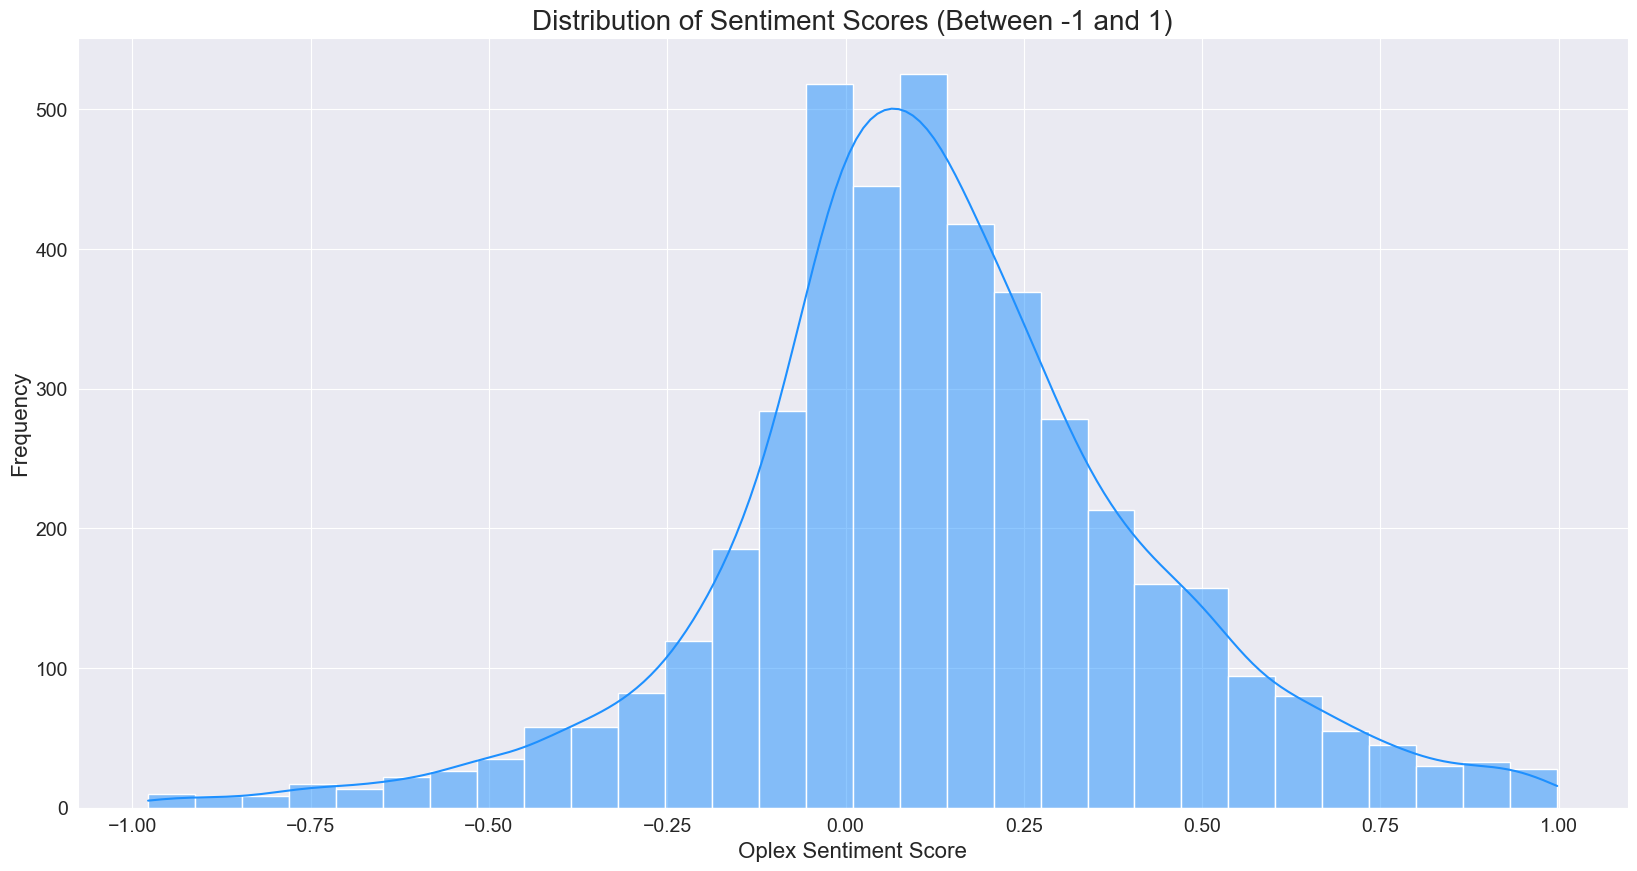

In [ ]:
# Create the figure and axis with appropriate size
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the histogram for sentiment scores within the specified range
sns.histplot(
    data=reviews.query("oplex_sentiment_score < 1 and oplex_sentiment_score > -1"), 
    x='oplex_sentiment_score', 
    bins=30,  # Adjust the number of bins for better granularity
    kde=True,  # Add Kernel Density Estimate for a smoother distribution curve
    color='dodgerblue',  # Set a custom color
    ax=ax
)

# Add labels and a title to the plot
ax.set_title('Distribution of Sentiment Scores (Between -1 and 1)', fontsize=20)
ax.set_xlabel('Oplex Sentiment Score', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)

# Improve tick label readability
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Display the plot
plt.show()

In [ ]:
conditions = [
    reviews['oplex_sentiment_score'] > 0.1,
    reviews['oplex_sentiment_score'] < 0
]

# Define the corresponding outputs for each condition
choices = ['positive', 'negative']

# Use numpy.select to vectorize the operation
reviews['oplex_sentiment'] = np.select(conditions, choices, default='neutral')

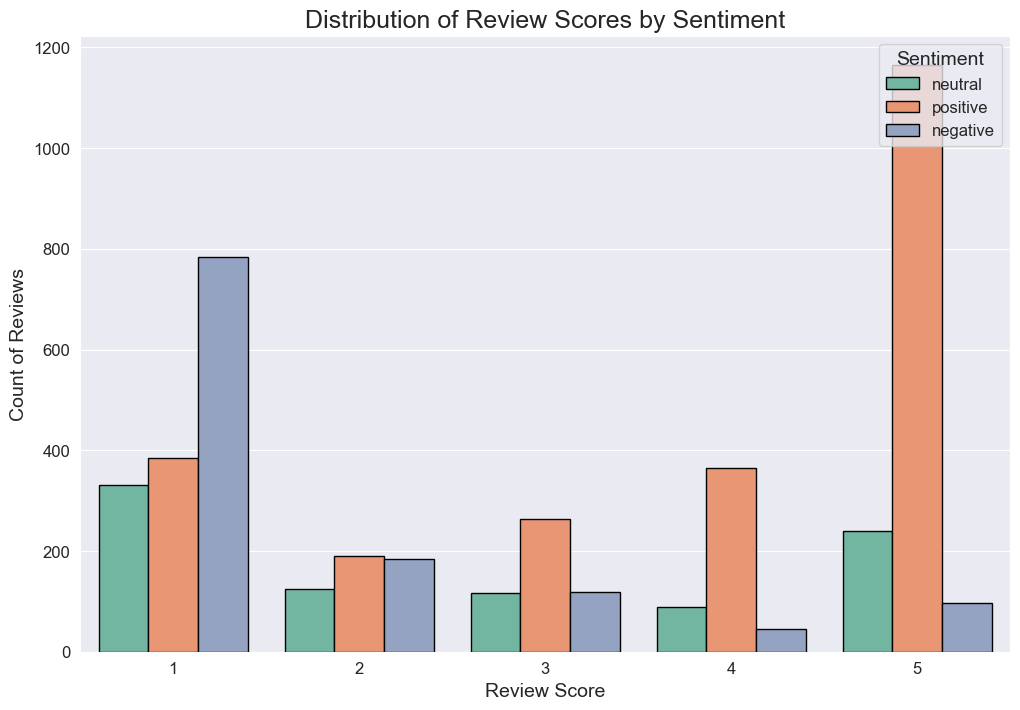

In [ ]:
# Set up the figure and axis
plt.figure(figsize=(12, 8))

# Create a count plot with 'Score' on the x-axis and 'oplex_sentiment' as the hue
sns.countplot(
    x='Score', 
    hue='oplex_sentiment', 
    data=reviews,
    palette='Set2',  # Use a distinct color palette
    edgecolor='black'  # Add edge color to the bars for better distinction
)

# Add labels and a title
plt.title('Distribution of Review Scores by Sentiment', fontsize=18)
plt.xlabel('Review Score', fontsize=14)
plt.ylabel('Count of Reviews', fontsize=14)

# Improve the legend
plt.legend(title='Sentiment', fontsize=12, title_fontsize=14, loc='upper right')

# Improve tick label readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

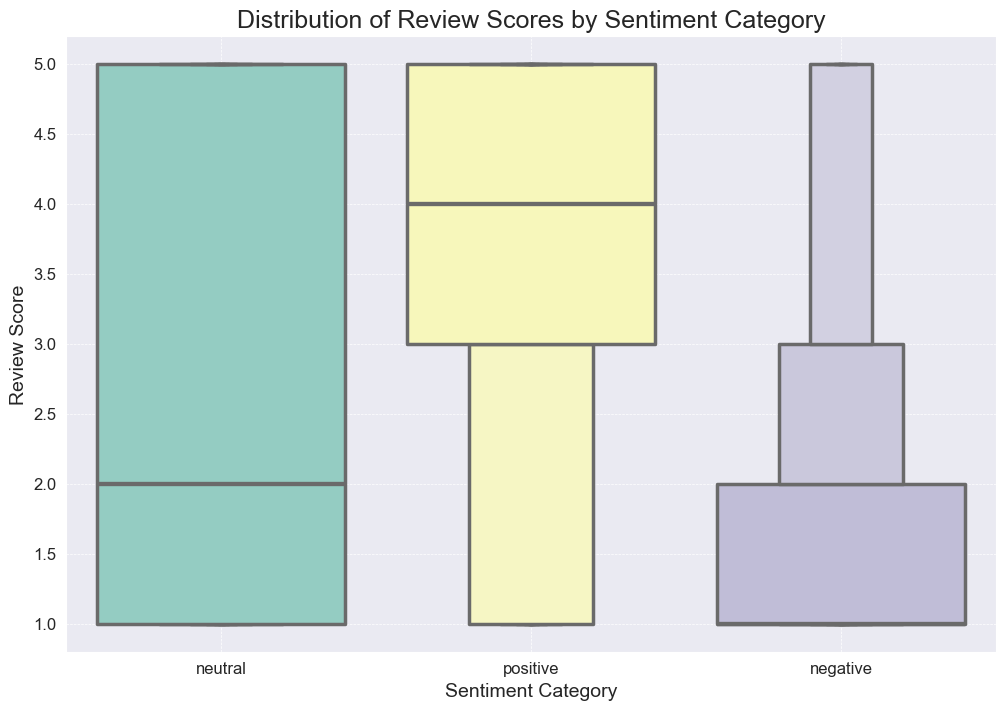

In [ ]:

# Set up the figure and axis
plt.figure(figsize=(12, 8))

# Create a boxen plot with 'oplex_sentiment' on the x-axis and 'Score' on the y-axis
sns.boxenplot(
    x='oplex_sentiment', 
    y='Score', 
    data=reviews,
    palette='Set3',  # Use a color palette that is distinct and visually appealing
    saturation=0.8,  # Adjust saturation for better color contrast
    linewidth=2.5  # Increase the line width for better visibility of the plot elements
)

# Add labels and a title
plt.title('Distribution of Review Scores by Sentiment Category', fontsize=18)
plt.xlabel('Sentiment Category', fontsize=14)
plt.ylabel('Review Score', fontsize=14)

# Improve tick label readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Optionally, add gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

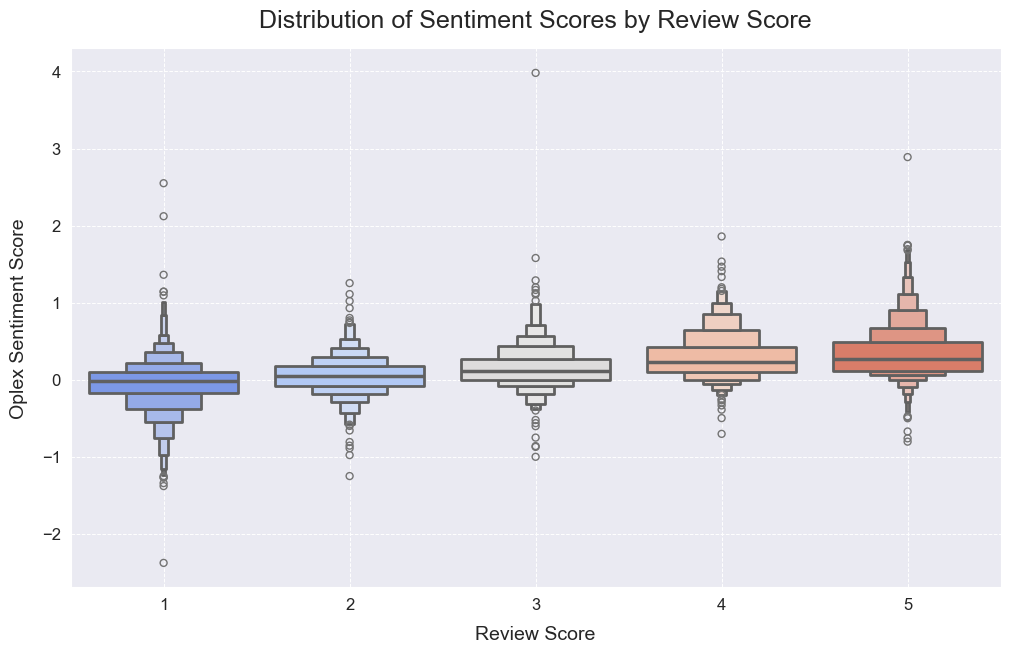

In [ ]:
# Set up the figure and axis with appropriate size
fig, ax = plt.subplots(figsize=(12, 7))

# Create a boxen plot with 'Score' on the x-axis and 'oplex_sentiment_score' on the y-axis
sns.boxenplot(
    x='Score', 
    y='oplex_sentiment_score', 
    data=reviews, 
    ax=ax,
    palette='coolwarm',  # Use a diverging color palette to highlight score distribution
    saturation=0.8,      # Adjust saturation for better color contrast
    linewidth=2          # Increase the line width for better visibility of the plot elements
)

# Add labels and a title
ax.set_title('Distribution of Sentiment Scores by Review Score', fontsize=18, pad=15)
ax.set_xlabel('Review Score', fontsize=14, labelpad=10)
ax.set_ylabel('Oplex Sentiment Score', fontsize=14, labelpad=10)

# Improve tick label readability
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add gridlines for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.7)

# Show the plot
plt.show()

<a href="#toc" style="background-color: blue; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a>

<a id="6"></a>
## <b><span style="color:teal">VADER Sentiment Scoring</span></b>

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a powerful sentiment analysis tool that’s specifically designed for social media content but works well with texts from other domains as well. Unlike traditional machine learning models, VADER is rule-based and doesn’t require extensive training data. Here are some key features of VADER:

1. **Lexicon-Based Approach**:  
   VADER uses a predefined list of words, known as a lexicon, where each word has an assigned sentiment score. These scores reflect whether the word is generally positive, negative, or neutral.

2. **Rule-Based Scoring**:  
   Instead of relying on complex statistical models, VADER applies straightforward rules to determine the sentiment of a text. These rules take into account things like:
   - **Negations** (e.g., "not good" is less positive than "good"),
   - **Punctuation** (e.g., "Good!" might be more positive than "Good"),
   - **Capitalization** (e.g., "GOOD" might be stronger than "good"),
   - **Emoticons** (e.g., ":)" is positive).

3. **Designed for Social Media**:  
   VADER excels in analyzing the kind of informal language, slang, and emoticons commonly found in social media posts.

4. **Efficiency**:  
   VADER is lightweight, meaning it uses fewer computing resources compared to machine learning models. This makes it quick and easy to use for sentiment analysis.

### How VADER Works:

- **In Simple Terms**:
   1. **Stop Words Removal**: VADER first removes common words that don't carry much sentiment (like "and", "the", "is").
   2. **Scoring Words**: It then looks at each remaining word in the text, assigns a sentiment score based on its lexicon, and combines these scores to give an overall sentiment score for the text.

### Applying VADER:

Using NLTK's `SentimentIntensityAnalyzer`, you can easily calculate the sentiment score of any text. This score will tell you if the text is overall negative, neutral, or positive.


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sentiment_intensity_analyzer= SentimentIntensityAnalyzer ()

In [ ]:
sentiment_intensity_analyzer.polarity_scores("I am so happy after eating cremica's dark chocolate brownie!")

{'neg': 0.0, 'neu': 0.651, 'pos': 0.349, 'compound': 0.6468}

In [ ]:
sentiment_intensity_analyzer.polarity_scores('This is the worst thing I have ever eaten.')

{'neg': 0.369, 'neu': 0.631, 'pos': 0.0, 'compound': -0.6249}

In [ ]:
example = reviews['Text'].iloc[20]
sentiment_intensity_analyzer.polarity_scores(example)

{'neg': 0.115, 'neu': 0.834, 'pos': 0.051, 'compound': -0.7118}

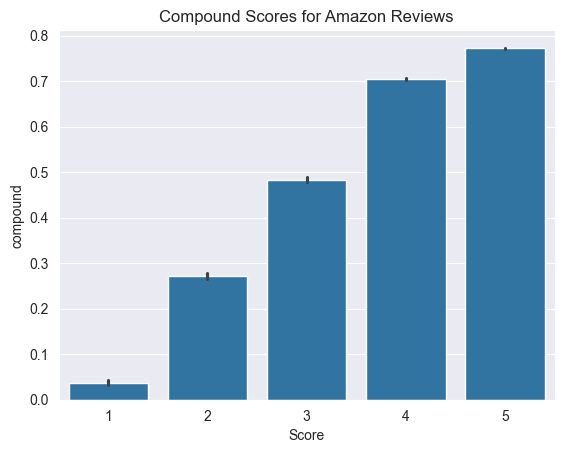

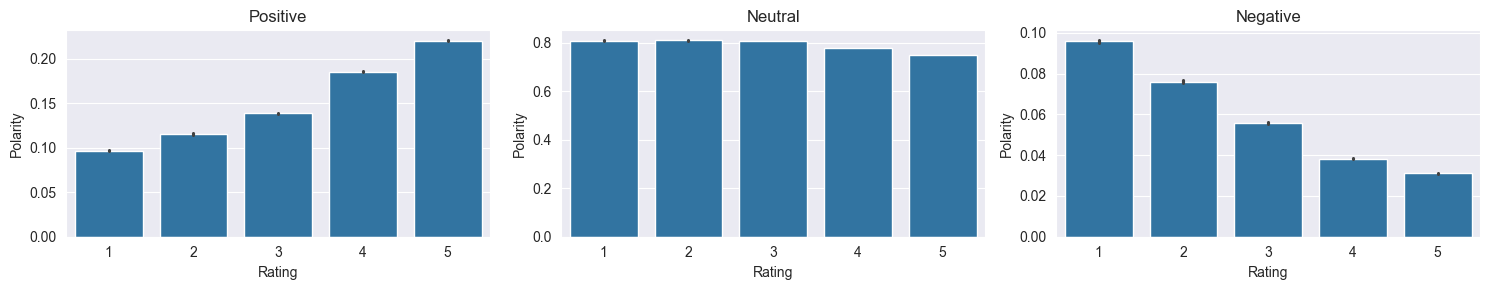

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Initialize VADER Sentiment Analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis to a single text
def analyze_sentiment(text):
    return sentiment_analyzer.polarity_scores(text)

# Function to speed up polarity score calculation using parallelism
def parallel_apply_sentiment(df, text_column):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(analyze_sentiment, df[text_column]))
    return pd.DataFrame(results)


# Apply sentiment analysis in parallel
polarity_df = parallel_apply_sentiment(df, 'Text')
polarity_df = polarity_df.reset_index(drop=True)
polarity_df['Id'] = df['Id']  # Keep track of original IDs

# Merge polarity scores with the original DataFrame
merged_df = pd.concat([df, polarity_df], axis=1)

# Plot compound scores for Amazon reviews
ax = sns.barplot(data=merged_df, x='Score', y='compound')
ax.set_title('Compound Scores for Amazon Reviews')

# Create subplots for positive, neutral, and negative scores
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

# Plot positive scores
sns.barplot(data=merged_df, x='Score', y='pos', ax=axs[0])
axs[0].set_title('Positive')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Polarity')

# Plot neutral scores
sns.barplot(data=merged_df, x='Score', y='neu', ax=axs[1])
axs[1].set_title('Neutral')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Polarity')

# Plot negative scores
sns.barplot(data=merged_df, x='Score', y='neg', ax=axs[2])
axs[2].set_title('Negative')
axs[2].set_xlabel('Rating')
axs[2].set_ylabel('Polarity')

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
print(res)

{1: {'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}, 2: {'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'compound': -0.5664}, 3: {'neg': 0.091, 'neu': 0.754, 'pos': 0.155, 'compound': 0.8265}, 4: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, 5: {'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'compound': 0.9468}, 6: {'neg': 0.029, 'neu': 0.809, 'pos': 0.163, 'compound': 0.883}, 7: {'neg': 0.034, 'neu': 0.693, 'pos': 0.273, 'compound': 0.9346}, 8: {'neg': 0.0, 'neu': 0.52, 'pos': 0.48, 'compound': 0.9487}, 9: {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.6369}, 10: {'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'compound': 0.8313}, 11: {'neg': 0.017, 'neu': 0.846, 'pos': 0.137, 'compound': 0.9746}, 12: {'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'compound': -0.7579}, 13: {'neg': 0.031, 'neu': 0.923, 'pos': 0.046, 'compound': 0.296}, 14: {'neg': 0.0, 'neu': 0.355, 'pos': 0.645, 'compound': 0.9466}, 15: {'neg': 0.104, 'neu': 0.632, 'pos': 0.264, 'compound': 0.6486}, 16: {'neg': 0.0

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(reviews, how='left')

In [ ]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,oplex_sentiment_score,oplex_sentiment
0,1,0.000,0.695,0.305,0.9441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.138,0.862,0.000,-0.5664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.091,0.754,0.155,0.8265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0.000,1.000,0.000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.000,0.552,0.448,0.9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


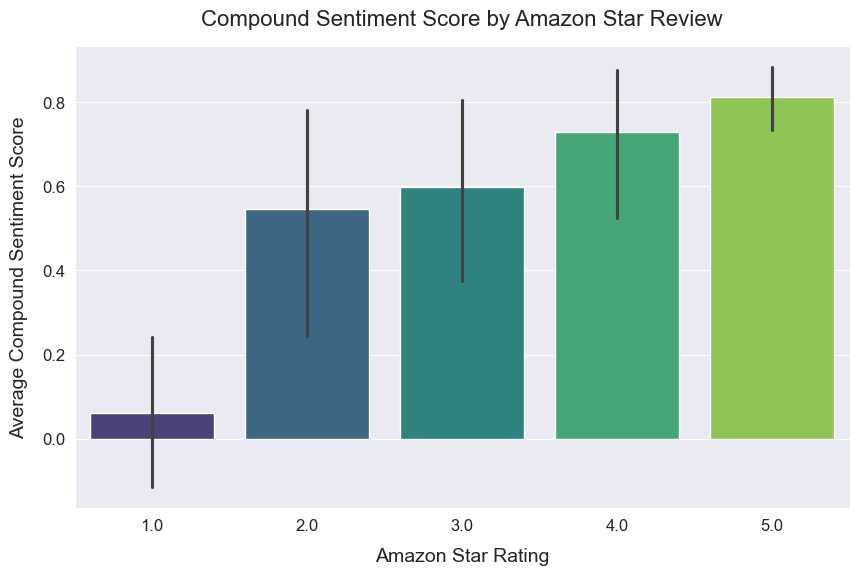

In [ ]:
# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Create the bar plot
ax = sns.barplot(data=vaders, x='Score', y='compound', palette='viridis')

# Add a title and labels
ax.set_title('Compound Sentiment Score by Amazon Star Review', fontsize=16, pad=15)
ax.set_xlabel('Amazon Star Rating', fontsize=14, labelpad=10)
ax.set_ylabel('Average Compound Sentiment Score', fontsize=14, labelpad=10)

# Improve tick label readability
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Show the plot
plt.show()

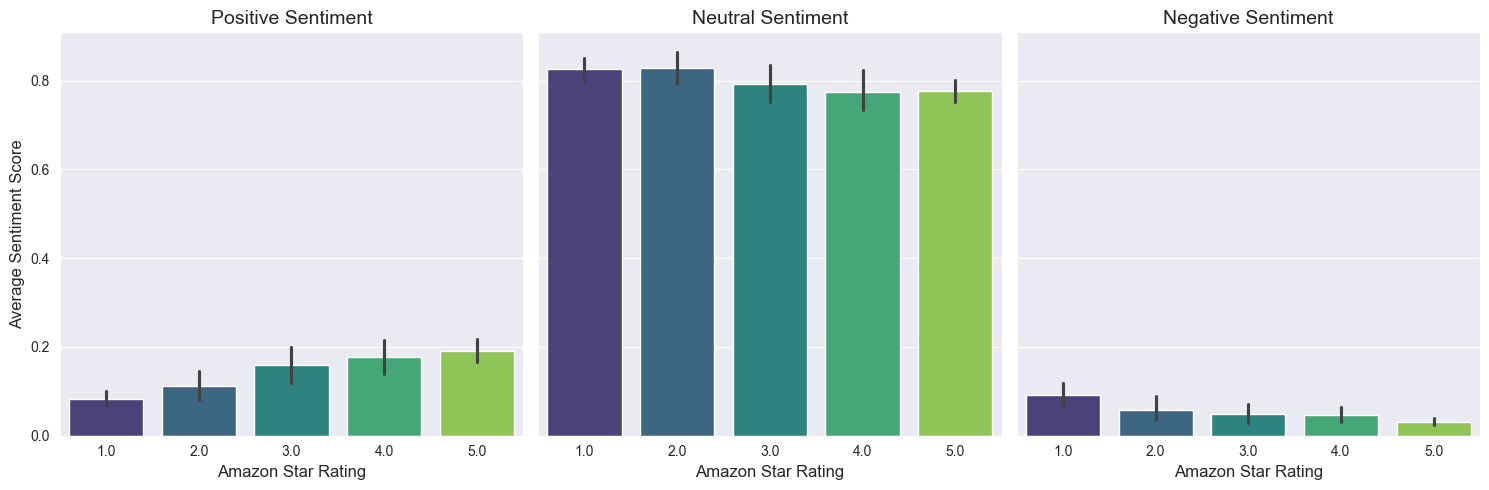

In [ ]:
# Set up the figure and axis with appropriate size
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Define a color palette for consistency
palette = 'viridis'

# Create the bar plots
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0], palette=palette)
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1], palette=palette)
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2], palette=palette)

# Set titles for each subplot
axs[0].set_title('Positive Sentiment', fontsize=14)
axs[1].set_title('Neutral Sentiment', fontsize=14)
axs[2].set_title('Negative Sentiment', fontsize=14)

# Set a common label for the x-axis
for ax in axs:
    ax.set_xlabel('Amazon Star Rating', fontsize=12)
    ax.set_ylabel('Average Sentiment Score', fontsize=12)

# Improve tick label readability
for ax in axs:
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [86]:


# Function to classify sentiment based on compound score
def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'
    

print(classify_sentiment(analyze_sentiment("The product is not good at all.")))


{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'compound': -0.3412}
